In [1]:
!pip install langchain
!pip install langchain_openai
!pip install langchain_anthropic
!pip install langchain_deepseek
!pip install langchain_community
!pip install langgraph
!pip install openai
!pip install python-dotenv
!pip install langgraph
!pip install httpx
!pip install requests
!pip install pygments
!pip install langgraph-checkpoint-sqlite
!apt-get install -y graphviz graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
# Import required libraries
import os
import sqlite3
import json
import datetime
import getpass
import re
from typing import Annotated, TypedDict, Dict, List, Union, Optional

# LangChain imports
from langchain.schema import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.runnables import RunnableLambda

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver

# LangSmith Tracer


#### Uncomment & Execute below code if you are using OpenAI api keys

In [3]:
# os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API KEY:")
# llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

#### Uncomment & Execute below code if you are using OpenAI api keys

In [4]:
if "ANTHROPIC_API_KEY" not in os.environ:
    os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", temperature=0.2)

Enter your Anthropic API key: ··········


#### Execute if you are using Anthropic API Keys

In [5]:
# if "DEEPSEEK_API_KEY" not in os.environ:
#     os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your Deepseek API key: ")
# llm = ChatDeepSeek(model="deepseek-chat", temperature=0.2)

In [6]:
def setup_mock_database():
    """Create and populate a mock SQLite database for user verification"""
    conn = sqlite3.connect('call_center.db')
    cursor = conn.cursor()

    # Create users table if it doesn't exist
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS users (
        id TEXT PRIMARY KEY,
        name TEXT,
        phone TEXT,
        dob TEXT
    )
    ''')

    # Sample user data - add a few mock users including our caller
    sample_users = [
        ('USR001', 'Raman Singh', '9973212398', '1982-03-15'),
        ('USR002', 'Priya Sharma', '8845671234', '1990-06-22'),
        ('USR003', 'Vikram Patel', '7712459876', '1975-11-08'),
        ('USR004', 'Ananya Gupta', '9956781234', '1988-09-30')
    ]

    # Create calls log table for tracking interactions
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS calls (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        user_id TEXT,
        transcript TEXT,
        verification_status TEXT,
        route TEXT,
        sentiment TEXT,
        timestamp DATETIME
    )
    ''')

    # Insert sample users
    cursor.executemany('INSERT OR REPLACE INTO users VALUES (?, ?, ?, ?)', sample_users)

    conn.commit()
    conn.close()

    print("Mock database setup completed.")

# Run the database setup
setup_mock_database()

Mock database setup completed.


In [7]:
import sqlite3

def setup_credit_card_transactions():
    """
    Create a 'credit_transactions' table and insert sample transactions
    for the sample users.
    """
    conn = sqlite3.connect('call_center.db')
    cursor = conn.cursor()

    # Create credit_transactions table if it doesn't exist.
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS credit_transactions (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            card_number TEXT,
            user_id TEXT,
            transaction_date DATETIME,
            amount INTEGER,
            transaction_type TEXT,  -- e.g., debit or credit
            description TEXT
        )
    ''')

    # Sample transactions for the four sample users.
    # Note: For USR001, USR002, and USR003 we already have sample cards in the credit_cards table.
    # For USR004 (Ananya Gupta), we add a sample credit card ("4444444444444444") entry in transactions
    # without a corresponding card in the sample credit_cards table.
    sample_transactions = [
        # USR001: Raman Singh, card: 4111111111111111
        ('4111111111111111', 'USR001', '2025-03-10 10:00:00', 100, 'debit', 'ATM transaction charge'),
        ('4111111111111111', 'USR001', '2025-03-11 12:00:00', 2500, 'debit', 'Electronics store purchase'),

        # USR002: Priya Sharma, card: 4222222222222222
        ('4222222222222222', 'USR002', '2025-03-09 15:30:00', 75, 'debit', 'Bank transaction fee'),
        ('4222222222222222', 'USR002', '2025-03-12 09:30:00', 500, 'debit', 'Grocery store purchase'),

        # USR003: Vikram Patel, card: 4333333333333333 (this card is marked as blocked in your sample)
        ('4333333333333333', 'USR003', '2025-03-08 08:00:00', 0, 'debit', 'Transaction attempt on blocked card'),

        # USR004: Ananya Gupta, using a sample card "4444444444444444"
        ('4444444444444444', 'USR004', '2025-03-11 11:00:00', 1000, 'debit', 'Restaurant purchase'),
        ('4444444444444444', 'USR004', '2025-03-13 14:00:00', 500, 'debit', 'Movie ticket')
    ]

    cursor.executemany('''
        INSERT INTO credit_transactions
        (card_number, user_id, transaction_date, amount, transaction_type, description)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', sample_transactions)

    conn.commit()
    conn.close()
    print("Credit card transactions setup completed.")

# Run this function to initialize the credit card transactions table
setup_credit_card_transactions()


Credit card transactions setup completed.


In [8]:
import sqlite3

def setup_credit_cards():
    """
    Create the 'credit_cards' table and insert sample credit card data
    for the four sample users. Each card includes:
      - card_number: The full card number (as text)
      - user_id: The ID of the user owning the card
      - last4: The last four digits of the card number
      - status: Card status such as active or blocked
      - credit_limit: The current credit limit
      - current_balance: The current outstanding balance on the card
    """
    conn = sqlite3.connect('call_center.db')
    cursor = conn.cursor()

    # Create credit_cards table if it doesn't exist.
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS credit_cards (
            card_number TEXT PRIMARY KEY,
            user_id TEXT,
            last4 TEXT,
            status TEXT,
            credit_limit INTEGER,
            current_balance INTEGER
        )
    ''')

    # Sample credit card records for your sample users.
    sample_cards = [
        ('4111111111111111', 'USR001', '1111', 'active', 50000, 1500),  # Raman Singh
        ('4222222222222222', 'USR002', '2222', 'active', 60000, 3000),  # Priya Sharma
        ('4333333333333333', 'USR003', '3333', 'blocked', 40000, 0),     # Vikram Patel
        ('4444444444444444', 'USR004', '4444', 'active', 45000, 2000)     # Ananya Gupta
    ]

    cursor.executemany('''
        INSERT OR REPLACE INTO credit_cards
        (card_number, user_id, last4, status, credit_limit, current_balance)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', sample_cards)

    conn.commit()
    conn.close()
    print("Credit cards setup completed.")

# Run this function before you call check_credit_card_status or start your interactive session.
setup_credit_cards()


Credit cards setup completed.


In [9]:
def check_credit_card_status(user_id, last4):
    """Query the credit_cards table for a given user and last 4 digits."""
    conn = sqlite3.connect('call_center.db')
    cursor = conn.cursor()
    cursor.execute('''
          SELECT * FROM credit_cards WHERE user_id = ? AND last4 = ?
    ''', (user_id, last4))
    row = cursor.fetchone()
    conn.close()
    if row:
        return {
            "card_number": row[0],
            "last4": row[2],
            "status": row[3],
            "credit_limit": row[4],
            "current_balance": row[5]
        }
    else:
        return None


In [10]:
def determine_route_after_verification(transcript):
    """Determine appropriate routing after verification"""
    prompt = f"""
    Given this call transcript:
    ---
    {transcript}
    ---
    Now that the caller has been successfully verified, determine which department they should be routed to:
    - CreditCard: For any credit card related issues, disputes, or questions
    - Loan: For any loan applications, payments, or questions
    - Sentiment: For general feedback, complaints, or praise not related to specific products

    Reply with ONLY one of these exact options: "CreditCard", "Loan", or "Sentiment".
    """

    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        decision = response.content.strip()

        valid_routes = ["CreditCard", "Loan", "Sentiment"]
        if decision not in valid_routes:
            # Look for partial matches
            for route in valid_routes:
                if route.lower() in decision.lower():
                    return route
            return "Sentiment"  # Default fallback

        return decision
    except Exception as e:
        print(f"Error determining route: {e}")
        return "Sentiment"  # Default fallback

In [11]:
class State(TypedDict):
    """State type for the call center application"""
    messages: List[Dict[str, str]]  # conversation history
    current_message: str            # the most recent message from the user
    agent_response: str             # current response from the agent
    route: str                      # current route: Verification, CreditCard, Loan, or Sentiment
    verification_result: Dict       # verification status/details
    sentiment_analysis: Optional[Dict]
    card_analysis: Optional[Dict]
    loan_suggestion: Optional[Dict]

In [12]:

def master_agent(state: Dict) -> Dict:
    """
    The Master Agent sets the initial routing to verification.
    """
    messages = state.get("messages", [])
    transcript = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in messages])

    prompt = f"""
        You are the Master Agent in a call center system.

        Given this call transcript:
        ---
        {transcript}
        ---
        IMPORTANT: All callers MUST go through verification first.
        After verification, they should be routed based on their issue:
        - CreditCard: For any credit card related issues, disputes, or questions
        - Loan: For any loan applications, payments, or questions
        - Sentiment: ONLY for general feedback not related to specific products

        Reply with ONLY "Verification" - no other responses are valid here.
        """

    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        decision = response.content.strip()
        valid_routes = ["Verification", "Loan", "CreditCard", "Sentiment"]
        if decision not in valid_routes:
            decision = "Verification"
    except Exception as e:
        print(f"Error in master_agent: {e}")
        decision = "Verification"

    updated_state = state.copy()
    updated_state["route"] = decision

    # Provide a greeting if this is the first interaction
    if len(messages) <= 1:
        updated_state["agent_response"] = "Welcome to our customer service center. How can I help you today?"

    return updated_state

In [13]:
def verification_agent(state: Dict) -> Dict:
    """
    The Verification Agent extracts and verifies caller information.
    """
    messages = state.get("messages", [])
    updated_state = state.copy()

    # When no messages have been provided yet, request information.
    if not messages:
        updated_state["agent_response"] = "Welcome to our verification process. Could you please provide your full name, phone number, and date of birth for verification?"
        return updated_state

    transcript = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in messages])

    # If already verified, decide the next route.
    if state.get("verification_result", {}).get("verified", False):
        route = determine_route_after_verification(transcript)
        updated_state["route"] = route

        if route == "CreditCard":
            updated_state["agent_response"] = "Thank you for verifying your identity. Could you provide more details about your credit card issue?"
        elif route == "Loan":
            updated_state["agent_response"] = "Thank you for verifying your identity. Could you tell me which type of loan you are interested in?"
        elif route == "Sentiment":
            updated_state["agent_response"] = "Thank you for verifying your identity. I'd love to hear your feedback or concerns."

        return updated_state

    # Extract caller information
    caller_info = extract_caller_info(transcript)
    if not caller_info.get("name") or not caller_info.get("phone") or not caller_info.get("dob"):
        updated_state["agent_response"] = "I need your full name, phone number, and date of birth to verify your identity. Could you please provide any missing information?"
        return updated_state

    # Verify using the database
    verification_result = verify_caller(caller_info)
    updated_state["verification_result"] = verification_result

    if verification_result["verified"]:
        route = determine_route_after_verification(transcript)
        updated_state["route"] = route
        updated_state["agent_response"] = f"Thank you for verifying your identity, {verification_result['name']}. How can I assist you today?"
    else:
        updated_state["agent_response"] = "I'm sorry, but I couldn't verify your information. Please re-check your details or let me connect you with a human agent for assistance."

    return updated_state

In [14]:
def check_credit_card_status(user_id, last4):
    """Query the credit_cards table for a given user and last 4 digits."""
    conn = sqlite3.connect('call_center.db')
    cursor = conn.cursor()
    cursor.execute('''
          SELECT * FROM credit_cards WHERE user_id = ? AND last4 = ?
    ''', (user_id, last4))
    row = cursor.fetchone()
    conn.close()
    if row:
        return {
            "card_number": row[0],
            "last4": row[2],
            "status": row[3],
            "credit_limit": row[4],
            "current_balance": row[5]
        }
    else:
        return None


In [32]:
def credit_card_agent(state: Dict) -> Dict:
    """
    Streamlined credit card agent that directly processes requests
    for known actions (blocking, upgrading, or increasing the credit limit)
    once the user's identity and card details are verified.
    """
    updated_state = state.copy()
    messages = state.get("messages", [])
    transcript = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in messages])

    # Ensure we have the last 4 digits from conversation (or prompt if missing)
    if "card_last4" not in state:
        # Try to detect the digits in the transcript
        match = re.search(r'\b\d{4}\b', transcript)
        if match:
            updated_state["card_last4"] = match.group(0)
        else:
            updated_state["agent_response"] = "For security, please provide the last 4 digits of your credit card."
            return updated_state

    card_last4 = updated_state["card_last4"]

    # Retrieve user_id from verification data
    user_id = state.get("verification_result", {}).get("user_id", None)
    if not user_id:
        updated_state["agent_response"] = "User verification is incomplete. Please verify your identity again."
        return updated_state

    # Look up card details
    card_info = check_credit_card_status(user_id, card_last4)
    if not card_info:
        updated_state["agent_response"] = "No matching credit card found for your account with the provided digits."
        return updated_state

    lower_transcript = transcript.lower()
    action = None

    if "block" in lower_transcript:
        action = "block"
    elif "upgrade" in lower_transcript:
        action = "upgrade"
    elif "increase" in lower_transcript or "credit limit" in lower_transcript:
        action = "increase"

    # Process the recognized action directly.
    if action == "block":
        # Update card status immediately.
        conn = sqlite3.connect('call_center.db')
        cursor = conn.cursor()
        cursor.execute('UPDATE credit_cards SET status = ? WHERE user_id = ? AND last4 = ?', ("blocked", user_id, card_last4))
        conn.commit()
        conn.close()
        updated_state["agent_response"] = "Your card has been blocked. A new card will be issued shortly. Thank you."
        return updated_state

    elif action == "upgrade":
        updated_state["agent_response"] = "Your card qualifies for an upgrade. I have processed your request, and you'll receive upgraded card details shortly. Thank you."
        return updated_state

    elif action == "increase":
        # Direct processing of a credit limit increase.
        # Look for a numeric value (desired increase amount) in the latest user message.
        last_user_message = ""
        for msg in reversed(state.get("messages", [])):
            if msg["role"] == "user":
                last_user_message = msg["content"]
                break
        # Try to find a number in that message.
        match = re.search(r'(\d+)', last_user_message)
        if match:
            desired_increase = int(match.group(1))
        else:
            # If not provided explicitly, assume a default desired increase.
            desired_increase = 10000

        new_limit = card_info["credit_limit"] + desired_increase

        # Update the credit limit in the database.
        conn = sqlite3.connect('call_center.db')
        cursor = conn.cursor()
        cursor.execute('UPDATE credit_cards SET credit_limit = ? WHERE user_id = ? AND last4 = ?', (new_limit, user_id, card_last4))
        conn.commit()
        conn.close()

        updated_state["agent_response"] = (
            f"Your credit limit has been successfully increased to {new_limit} rupees. "
            "A confirmation email will be sent to you shortly. Thank you for your request!"
        )
        return updated_state

    else:
        # Fallback if the action is ambiguous.
        updated_state["agent_response"] = (
            "I have detected a credit card request. Could you please specify if you want to block, upgrade, or increase your credit limit?"
        )
        return updated_state


In [16]:
def loan_agent(state: Dict) -> Dict:
    """
    The Loan Agent extracts customer information and proposes loan options.
    """
    messages = state.get("messages", [])
    transcript = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in messages])

    customer_info = extract_customer_info(transcript)
    loan_suggestion = generate_loan_proposal(customer_info, transcript)

    updated_state = state.copy()
    updated_state["loan_suggestion"] = loan_suggestion
    updated_state["agent_response"] = loan_suggestion.get("support_specialist_script", "Could you please share more about your loan requirements?")

    return updated_state

In [17]:
def sentiment_agent(state: Dict) -> Dict:
    """
    The Sentiment Agent analyzes the emotional tone and provides an empathetic response.
    """
    messages = state.get("messages", [])
    transcript = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in messages])

    sentiment_analysis = analyze_sentiment(transcript)
    updated_state = state.copy()
    updated_state["sentiment_analysis"] = sentiment_analysis
    updated_state["agent_response"] = sentiment_analysis.get("empathy_response", "Thank you for your feedback. How else may I help you?")

    return updated_state

In [18]:
def extract_caller_info(transcript):
    """Extract caller's name, phone number, and date of birth from transcript"""
    prompt = f"""
Extract the following information from this call transcript:
- Full name of the caller
- Phone number
- Date of birth (in YYYY-MM-DD format)

Transcript:
{transcript}

Respond ONLY in this exact JSON format:
{{
  "name": "Full Name",
  "phone": "1234567890",
  "dob": "YYYY-MM-DD"
}}
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        content = response.content.strip()
        try:
            info = json.loads(content)
        except json.JSONDecodeError:
            # Fallback to regex extraction if needed
            info = {}
            name_match = re.search(r'"name"\s*:\s*"([^"]+)"', content)
            phone_match = re.search(r'"phone"\s*:\s*"([^"]+)"', content)
            dob_match = re.search(r'"dob"\s*:\s*"([^"]+)"', content)
            info["name"] = name_match.group(1) if name_match else ""
            info["phone"] = phone_match.group(1) if phone_match else ""
            info["dob"] = dob_match.group(1) if dob_match else ""

        # Normalize the date format if needed
        if info.get("dob") and "-" not in info["dob"]:
            try:
                from datetime import datetime
                date_formats = ["%B %d, %Y", "%b %d, %Y", "%d/%m/%Y", "%m/%d/%Y"]
                for fmt in date_formats:
                    try:
                        date_obj = datetime.strptime(info["dob"], fmt)
                        info["dob"] = date_obj.strftime("%Y-%m-%d")
                        break
                    except ValueError:
                        continue
            except Exception as e:
                print(f"Date normalization error: {e}")
        return info
    except Exception as e:
        print(f"Error extracting caller info: {e}")
        return {}

In [19]:
def verify_caller(caller_info):
    """Verify caller against the database"""
    try:
        conn = sqlite3.connect('call_center.db')
        cursor = conn.cursor()

        cursor.execute("""
            SELECT * FROM users
            WHERE name = ? AND phone = ? AND dob = ?
        """, (caller_info['name'], caller_info['phone'], caller_info['dob']))
        user = cursor.fetchone()
        conn.close()

        if user:
            return {"verified": True, "user_id": user[0], "name": user[1]}
        else:
            return {"verified": False, "reason": "User information doesn't match our records"}
    except Exception as e:
        print(f"Error verifying caller: {e}")
        return {"verified": False, "reason": f"Database error: {str(e)}"}

In [20]:
def extract_customer_info(transcript):
    """Extract customer information relevant for loan recommendations"""
    prompt = f"""
Extract the following customer information from this call transcript:
- Age (calculate from DOB if mentioned)
- Profession or occupation
- Income level (if mentioned)
- Current loans (if mentioned)
- Loan purpose (if mentioned)

Transcript:
{transcript}

Respond with ONLY a JSON object in this exact format:
{{
    "age": "extracted or calculated age",
    "profession": "extracted profession",
    "income": "extracted income or 'unknown'",
    "current_loans": "extracted loans or 'unknown'",
    "loan_purpose": "extracted purpose or 'unknown'"
}}
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        content = response.content.strip()
        json_match = re.search(r'({.*})', content.replace('\n', ' '), re.DOTALL)
        if json_match:
            info = json.loads(json_match.group(1))
            return info
    except Exception as e:
        print(f"Error extracting customer info: {e}")
    # Default values if extraction fails
    return {
        "age": "40",
        "profession": "unknown",
        "income": "unknown",
        "current_loans": "unknown",
        "loan_purpose": "unknown"
    }

In [21]:
def generate_loan_proposal(customer_info, transcript):
    """Generate loan suggestions based on customer information"""
    prompt = f"""
Based on this customer information:
- Age: {customer_info.get('age', 'unknown')}
- Profession: {customer_info.get('profession', 'unknown')}
- Income: {customer_info.get('income', 'unknown')}
- Current loans: {customer_info.get('current_loans', 'unknown')}
- Loan purpose: {customer_info.get('loan_purpose', 'unknown')}

And this transcript:
{transcript}

Propose appropriate loan options. Consider:
1. Personal loans (8-15% interest)
2. Home loans (6-9% interest)
3. Auto loans (7-12% interest)
4. Education loans (4-8% interest)
5. Business loans (10-18% interest)

Also provide a script for the support specialist to communicate with the customer.

Respond with ONLY a JSON object in this format:
{{
    "recommended_loan_types": ["list of top 2 recommended loan types"],
    "interest_range": "interest range for primary recommendation",
    "max_amount": "suggested maximum loan amount",
    "tenure_options": ["list of suggested tenures in years"],
    "support_specialist_script": "script for support specialist"
}}
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        content = response.content.strip()
        json_match = re.search(r'({.*})', content.replace('\n', ' '), re.DOTALL)
        if json_match:
            proposal = json.loads(json_match.group(1))
            return proposal
    except Exception as e:
        print(f"Error generating loan proposal: {e}")
    # Default proposal if generation fails
    return {
        "recommended_loan_types": ["Personal Loan", "Credit Card Balance Transfer"],
        "interest_range": "10-12%",
        "max_amount": "Based on income verification",
        "tenure_options": ["3 years", "5 years"],
        "support_specialist_script": "Based on our conversation, I'd recommend a Personal Loan with competitive interest rates between 10-12%. Would you like more details on the application process?"
    }

In [22]:
def analyze_card_issues(transcript):
    """Analyze credit card related issues in the transcript"""
    prompt = f"""
Analyze this transcript for credit card related issues:

{transcript}

Determine:
1. Issue type: dispute, fraud, upgrade request, information request, or other
2. Urgency level: high, medium, or low
3. Required actions
4. Card recommendations (if applicable)

Respond with ONLY a JSON object in this format:
{{
    "issue_type": "identified issue type",
    "urgency": "urgency level",
    "actions_required": ["list of required actions"],
    "card_recommendations": ["list of card recommendations or empty if not applicable"],
    "support_response": "suggested response for the support specialist"
}}
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        content = response.content.strip()
        json_match = re.search(r'({.*})', content.replace('\n', ' '), re.DOTALL)
        if json_match:
            analysis = json.loads(json_match.group(1))
            return analysis
    except Exception as e:
        print(f"Error analyzing card issues: {e}")
    # Default response
    return {
        "issue_type": "general inquiry",
        "urgency": "medium",
        "actions_required": ["Provide information", "Assess customer needs"],
        "card_recommendations": ["Rewards Card", "Premium Travel Card"],
        "support_response": "Could you please provide more details about your credit card concerns?"
    }


In [23]:

def analyze_sentiment(transcript):
    """Analyze the sentiment of the call transcript"""
    prompt = f"""
Analyze the emotional tone and sentiment in this call transcript:

{transcript}

Determine:
1. Overall sentiment: positive, negative, or neutral
2. Customer emotion: e.g., frustrated, angry, confused, satisfied, etc.
3. Urgency level: high, medium, or low
4. Key concerns expressed

Respond with ONLY a JSON object in this format:
{{
    "sentiment": "overall sentiment",
    "emotion": "primary customer emotion",
    "urgency": "urgency level",
    "concerns": ["list of key concerns"],
    "empathy_response": "suggested empathetic response for support specialist",
    "escalation_needed": true/false
}}
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        content = response.content.strip()
        json_match = re.search(r'({.*})', content.replace('\n', ' '), re.DOTALL)
        if json_match:
            analysis = json.loads(json_match.group(1))
            return analysis
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
    # Default sentiment analysis
    return {
        "sentiment": "neutral",
        "emotion": "inquiring",
        "urgency": "medium",
        "concerns": ["General assistance needed"],
        "empathy_response": "I appreciate you reaching out. Could you please provide more details about your concerns?",
        "escalation_needed": False
    }

In [24]:
import re

def process_user_message(state: Dict, message: str) -> Dict:
    updated_state = state.copy()

    # Check if the previous agent response asked for the last 4 digits
    last_agent_response = ""
    for msg in reversed(updated_state.get("messages", [])):
        if msg["role"] == "assistant":
            last_agent_response = msg["content"]
            break
    if "last 4 digits" in last_agent_response.lower():
        # Try to extract a 4-digit number from the user's message.
        match = re.search(r'\b\d{4}\b', message)
        if match:
            updated_state["card_last4"] = match.group(0)
            print(f"[DEBUG] Captured card_last4: {updated_state['card_last4']}")

    updated_state.setdefault("messages", []).append({
        "role": "user",
        "content": message
    })
    updated_state["current_message"] = message
    return updated_state


In [25]:
def log_conversation_to_db(state: Dict) -> None:
    """Log the current conversation to the database"""
    try:
        conn = sqlite3.connect('call_center.db')
        cursor = conn.cursor()
        messages = state.get("messages", [])
        transcript = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in messages])
        verification_result = state.get("verification_result", {"verified": False})
        verification_status = "verified" if verification_result.get("verified") else "not_verified"
        user_id = verification_result.get("user_id", "unknown")
        route = state.get("route", "unknown")
        sentiment = state.get("sentiment_analysis", {}).get("sentiment", "unknown")
        cursor.execute("""
            INSERT INTO calls (user_id, transcript, verification_status, route, sentiment, timestamp)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (user_id, transcript, verification_status, route, sentiment, datetime.datetime.now()))
        conn.commit()
        conn.close()
        print("Conversation logged to database.")
    except Exception as e:
        print(f"Error logging conversation: {e}")

In [26]:
def wait_for_user_agent(state: Dict) -> Dict:
    """
    A node that simply returns the state as is.
    It serves as a pause so that the interactive_message_handler() can wait for new input.
    """
    # You might optionally set or update an agent_response here.
    # In our Verification agent, we already set a prompt asking for verification details.
    # So, here we just return the state.
    return state

In [27]:
def build_call_center_graph():
    """Build the state machine including the credit card agent node."""
    builder = StateGraph(State)

    builder.add_node("MasterAgent", master_agent)
    builder.add_node("Verification", verification_agent)
    builder.add_node("CreditCard", credit_card_agent)
    builder.add_node("Loan", loan_agent)
    builder.add_node("Sentiment", sentiment_agent)
    builder.add_node("Wait", wait_for_user_agent)  # to break recursion if needed

    # START -> MasterAgent
    builder.add_edge(START, "MasterAgent")

    builder.add_conditional_edges(
        "MasterAgent",
        lambda s: "to_end" if s.get("terminate", False) else "Verification",
        {"Verification": "Verification", "to_end": END}
    )

    # In Verification, if not verified, wait; once verified, use the extracted route.
    builder.add_conditional_edges(
        "Verification",
        lambda s: s.get("route") if s.get("verification_result", {}).get("verified", False) else "Wait",
        {"CreditCard": "CreditCard", "Loan": "Loan", "Sentiment": "Sentiment", "Wait": "Wait"}
    )

    # CreditCard and Loan both route to Sentiment, then Sentiment routes to END.
    builder.add_edge("CreditCard", "Sentiment")
    builder.add_edge("Loan", "Sentiment")
    builder.add_edge("Sentiment", END)

    graph = builder.compile()
    return graph


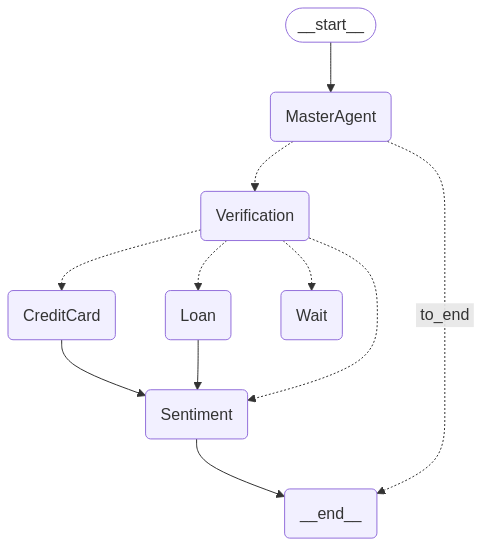

In [28]:
build_call_center_graph()

In [29]:
def get_sentiment_face(text: str) -> str:
    """
    Analyze the sentiment for the given text and return an emoticon.
    This uses the existing analyze_sentiment function.
    """
    try:
        # Use the current sentiment analysis on the user's input
        analysis = analyze_sentiment(text)
        sentiment = analysis.get("sentiment", "neutral").lower()
        emotion = analysis.get("emotion", "neutral").lower()

        # Map sentiment/emotion to a basic emoticon:
        if sentiment == "positive" or "happy" in emotion:
            return "😊"
        elif sentiment == "negative":
            # Check if angry is mentioned
            if "angry" in emotion:
                return "😠"
            else:
                return "😢"
        elif sentiment == "neutral":
            return "😐"
        else:
            return "🙂"
    except Exception as e:
        print("Error in sentiment analysis:", e)
        return "🙂"

In [30]:
def interactive_message_handler():
    """Handle interactive messaging for the call center simulation with sentiment feedback."""
    # (Re)set the mock database (can be removed if already initialized)
    setup_mock_database()

    # Build the state graph
    graph = build_call_center_graph()

    # Initialize state with an empty conversation history.
    state = {
        "messages": [],
        "route": "Verification"  # always start with verification for security
    }

    print("Welcome to the AI Call Center Simulation!")
    print("Please type your message (or type 'exit' to quit) and press Enter.\n")

    while True:
        # Get the user input
        user_input = input("You: ")
        if user_input.lower() in ('exit', 'quit', 'bye'):
            print("\nAgent: Thank you for contacting our customer service. Have a great day!")
            break

        # Analyze user's sentiment and print an emoticon
        sentiment_face = get_sentiment_face(user_input)
        print(f"Sentiment: {sentiment_face}")

        # Process the user message and update the state
        state = process_user_message(state, user_input)

        # Invoke the state graph to continue the workflow.
        state = graph.invoke(state)

        # Display the agent's response
        agent_response = state.get("agent_response", "I'm still processing your request. Could you please provide more information?")
        print(f"\nAgent: {agent_response}")

        # Append the agent's response to the conversation history
        state["messages"].append({
            "role": "assistant",
            "content": agent_response
        })

    # Log conversation after exit
    log_conversation_to_db(state)
    return state


In [33]:
interactive_state = interactive_message_handler()

Mock database setup completed.
Welcome to the AI Call Center Simulation!
Please type your message (or type 'exit' to quit) and press Enter.

You: increase credit card limit
Sentiment: 😐

Agent: I need your full name, phone number, and date of birth to verify your identity. Could you please provide any missing information?
You: Sure, my name is Raman Singh, my phone number is 9973212398, and my date of birth is March 15, 1982.
Sentiment: 😐

Agent: Thank you for providing your information, Mr. Singh. I understand you're interested in increasing your credit card limit. I'd be happy to help you with that request today.
You: ok
Sentiment: 😐

Agent: I notice you're interested in increasing your credit card limit, Mr. Singh. I'd be happy to explain the process and options available to you. Is there a specific reason you're looking for an increase, or a particular amount you have in mind?
You: 5000
Sentiment: 😐

Agent: I understand you're looking for a $5,000 credit limit increase, Mr. Singh. 